# Structure

#### * [Dataset](#dataset)
#### * [Logistic Regression with scikit-learn](#lr_scikit)
#### * [Logistic Regression with PyTorch](#lr_pytorch)


In [731]:
import numpy as np
import pandas as pd
import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix, ConfusionMatrixDisplay


import matplotlib.pyplot as plt

## <a id='dataset'>Dataset</a>

In [732]:
dataset = pd.read_csv('homework8_data.csv')

In [733]:
# Data scaling: min-max normalization
dataset[['age', 'fare']] = minmax_scale(dataset[['age', 'fare']])

In [734]:
dataset = dataset.rename(columns={'sex': 'isFemale'})

In [735]:
# One-hot encoding for pclass column
dataset['is_1st_class'] = dataset['pclass'].apply(lambda x: 1 if x == 1 else 0)
dataset['is_2nd_class'] = dataset['pclass'].apply(lambda x: 1 if x == 2 else 0)
dataset['is_3d_class'] = dataset['pclass'].apply(lambda x: 1 if x == 3 else 0)
dataset = dataset.drop(columns=['pclass'])

In [736]:
# One-hot encoding for embarked
dataset['cherbourg_port'] = dataset['embarked'].apply(lambda x: 1 if x == 0 else 0)
dataset['queenstown_port'] = dataset['embarked'].apply(lambda x: 1 if x == 1 else 0)
dataset['southampton_port'] = dataset['embarked'].apply(lambda x: 1 if x == 2 else 0)
dataset = dataset.drop(columns=['embarked'])

In [737]:
dataset.head(10)

,age,fare,isFemale,survived,is_1st_class,is_2nd_class,is_3d_class,cherbourg_port,queenstown_port,southampton_port
0,0.273456,0.014151,0,0,0,0,1,0,0,1
1,0.473882,0.139136,1,1,1,0,0,1,0,0
2,0.323563,0.015469,1,1,0,0,1,0,0,1
3,0.436302,0.103644,1,1,1,0,0,0,0,1
4,0.436302,0.015713,0,0,0,0,1,0,0,1
5,0.348616,0.016510,0,0,0,0,1,0,1,0
6,0.674308,0.101229,0,0,1,0,0,0,0,1
7,0.022924,0.041136,0,0,0,0,1,0,0,1
8,0.336089,0.021731,1,1,0,0,1,0,0,1
9,0.173243,0.058694,1,1,0,1,0,1,0,0


In [738]:
# Training and test datasets preparation
X = dataset.drop(columns=['survived']).to_numpy()
y = dataset['survived'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## <a id='lr_scikit'>Logistic Regression with scikit-learn</a>

In [739]:
def plot_conf_mtrx(original, predicted, title: str):
    labels = np.sort(np.unique(original))
    conf_mtrx = confusion_matrix(original, predicted, labels=labels)
    cm_plot = ConfusionMatrixDisplay(confusion_matrix = conf_mtrx, display_labels = labels)
    cm_plot.plot()
    plt.title(title)
    plt.show()

In [740]:
# Hyperparameters initialization
penalty = None
random_state = 9
solver = "newton-cholesky"

C_s = [0.001, 0.01, 0.1, 1, 5, 8, 10, 15, 30, 50, 100, 150, 200]
max_iters = [100, 200, 300, 400]

In [741]:
def plot_cross_entropy_n_c(x_axis_vals: list, train_losses: list, test_losses: list, title: str, x_label: str):
    plt.figure(figsize=(10, 6))
    plt.plot(x_axis_vals, train_losses, label='Train Binary Cross-Entrypy', marker='o')
    plt.plot(x_axis_vals, test_losses, label='Test Binary Cross-Entrypy', marker='o')
    plt.xlabel(x_label)
    plt.ylabel('Log Loss')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

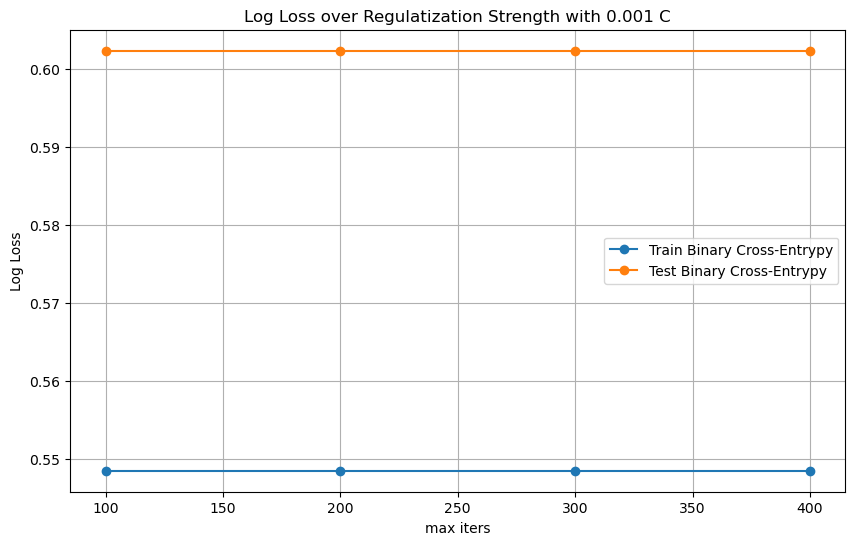

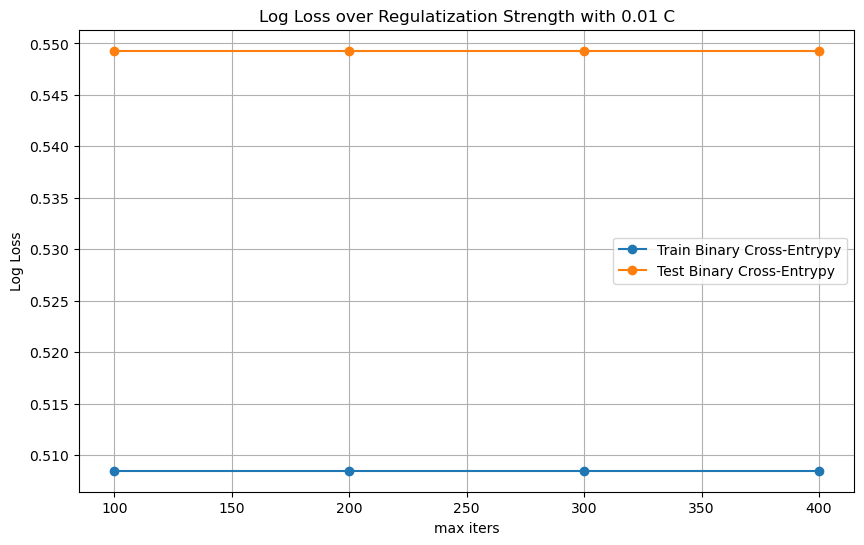

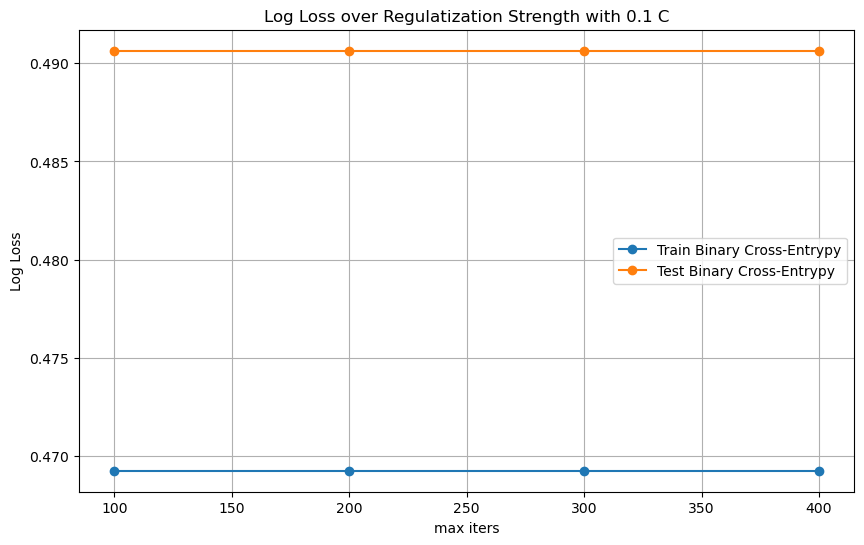

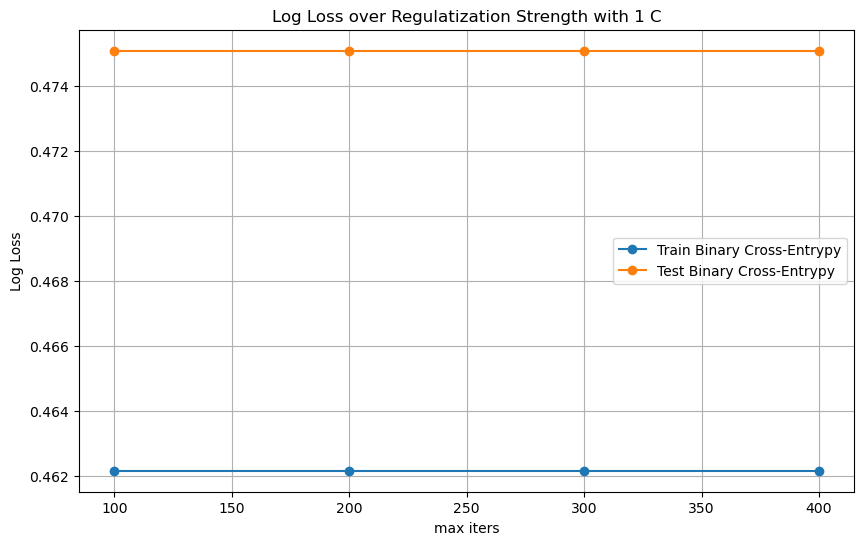

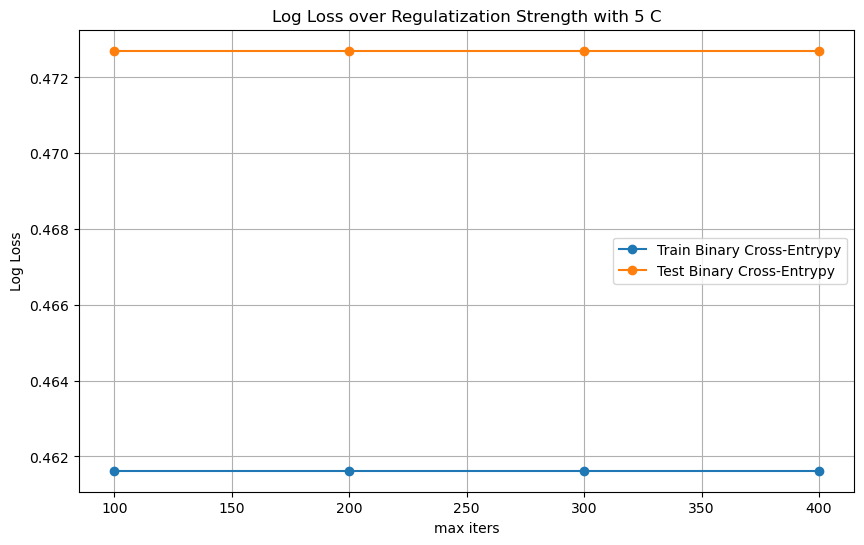

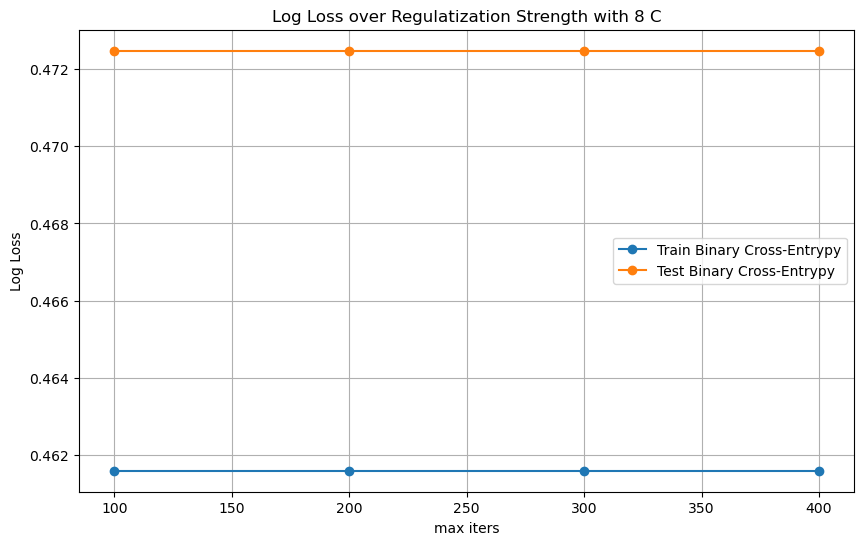

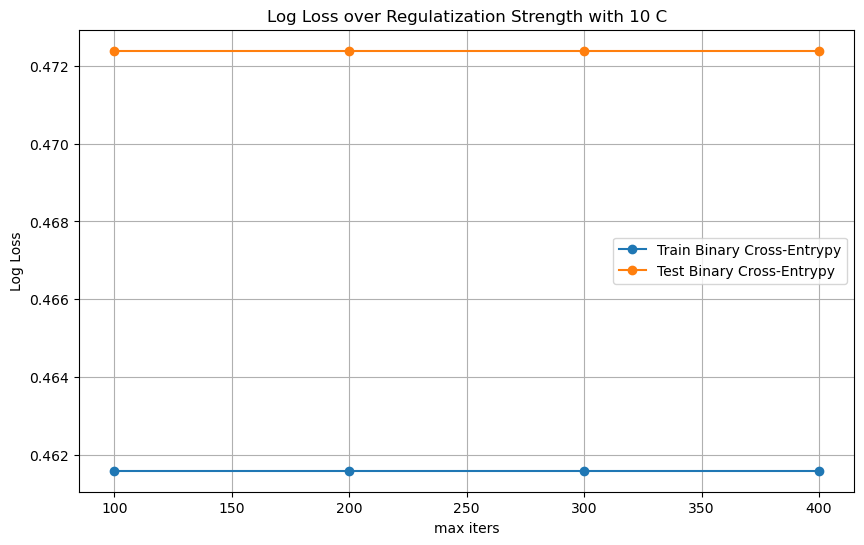

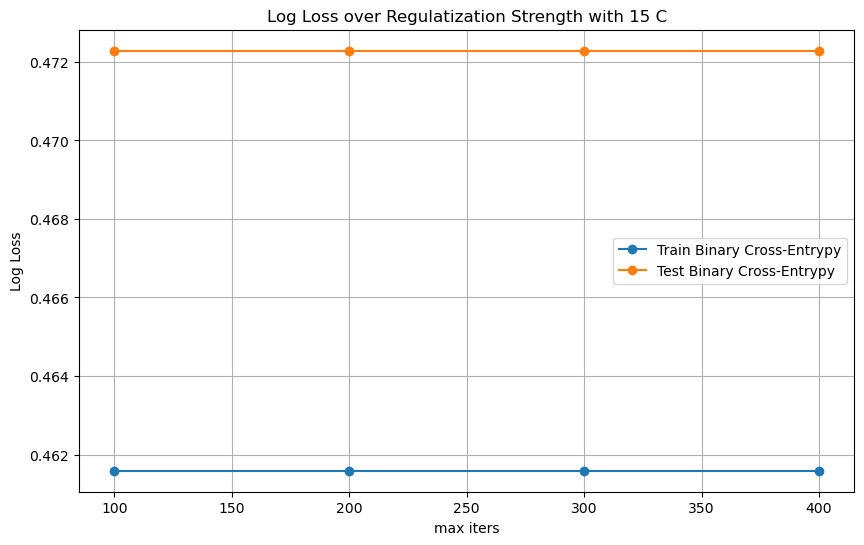

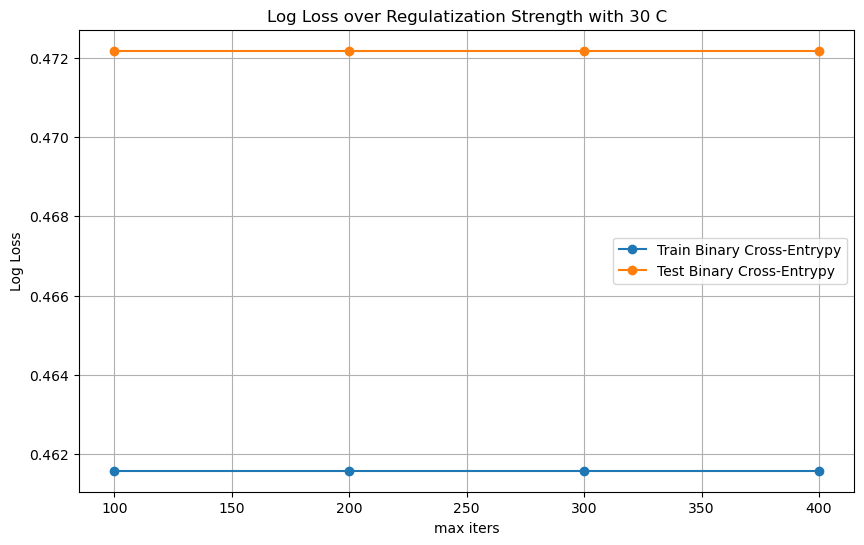

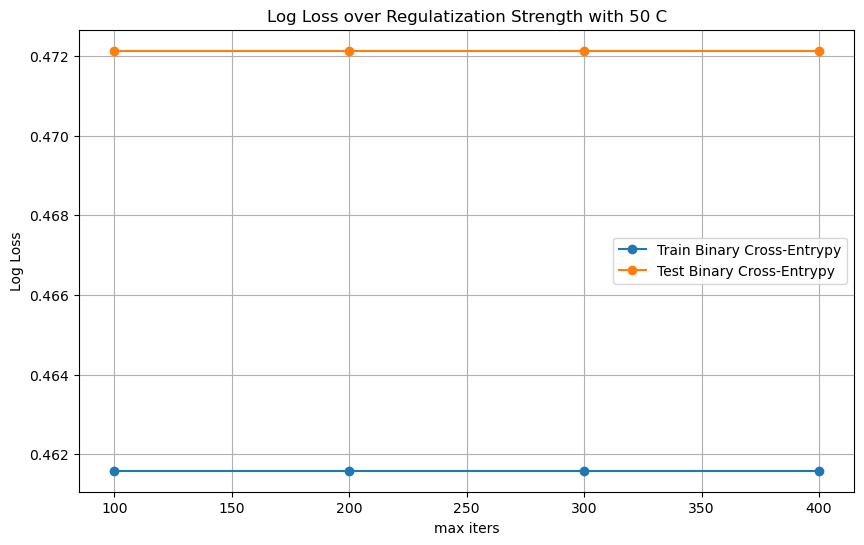

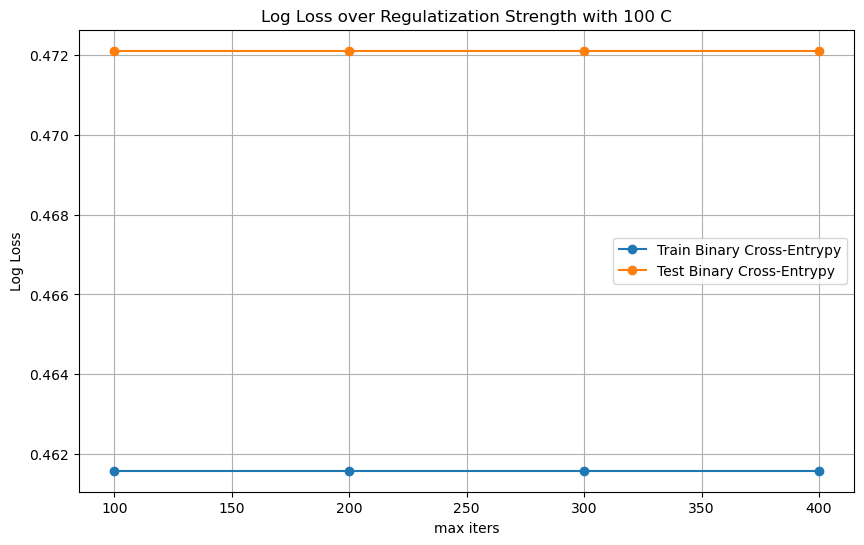

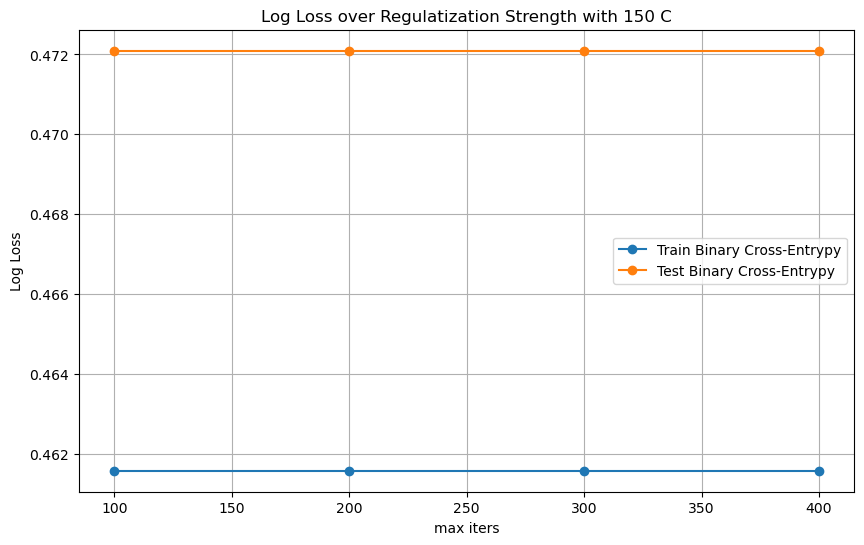

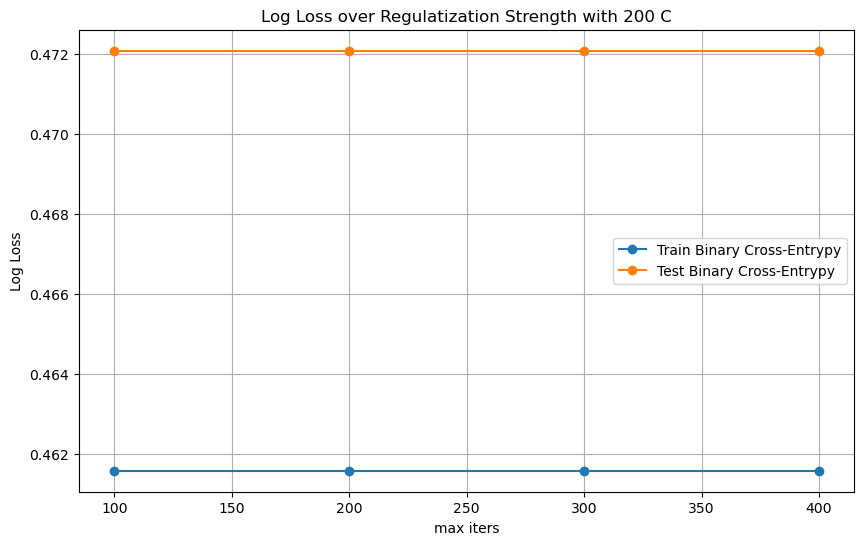

In [742]:
score = None
best_model = None


for reg in C_s:
    train_losses = []
    test_losses = []
    for max_iter in max_iters:
        clf = LogisticRegression(
            random_state=random_state,
            solver=solver,
            # penalty=penalty, ## I do not use None as penalty value since it means no regularization and thus ignoring C parameter
            C=reg,
            max_iter=max_iter
        )
        clf.fit(X_train, y_train)
        current_score = clf.score(X_test, y_test)

        y_train_proba = clf.predict_proba(X_train)
        y_test_proba = clf.predict_proba(X_test)
        
        train_loss = log_loss(y_train, y_train_proba)
        test_loss = log_loss(y_test, y_test_proba)
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)

        if score is None:
            score = current_score
            best_model = clf
        elif current_score > score:
            score = current_score
            best_model = clf

    plot_cross_entropy_n_c(
        x_axis_vals=max_iters, 
        train_losses=train_losses, 
        test_losses=test_losses, 
        title=f"Log Loss over Regulatization Strength with {reg} C",
        x_label="max iters"
        )


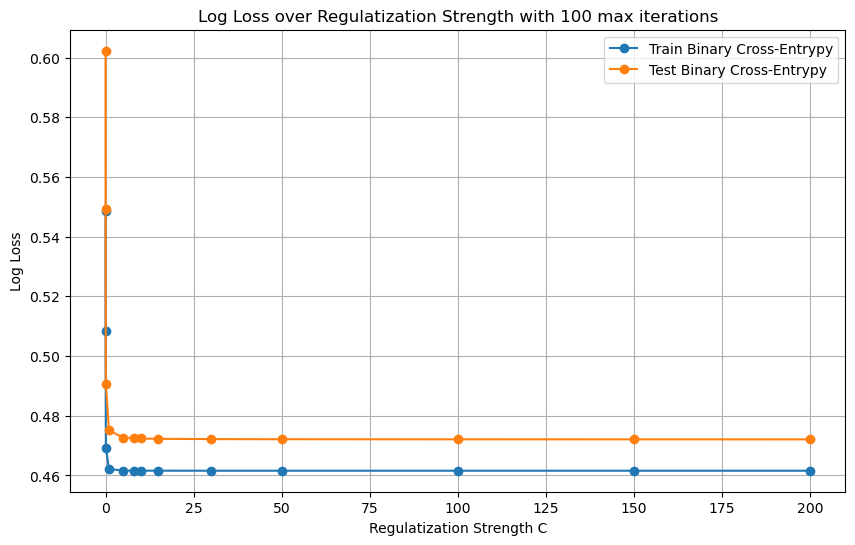

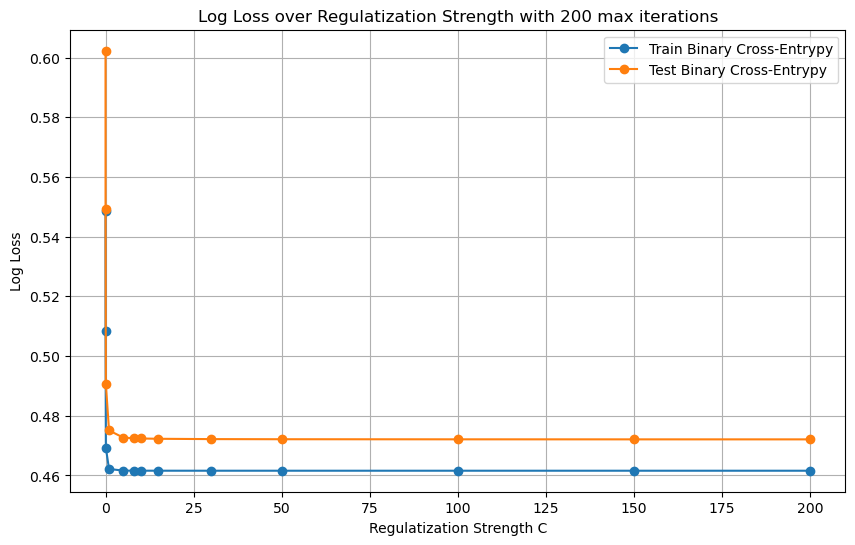

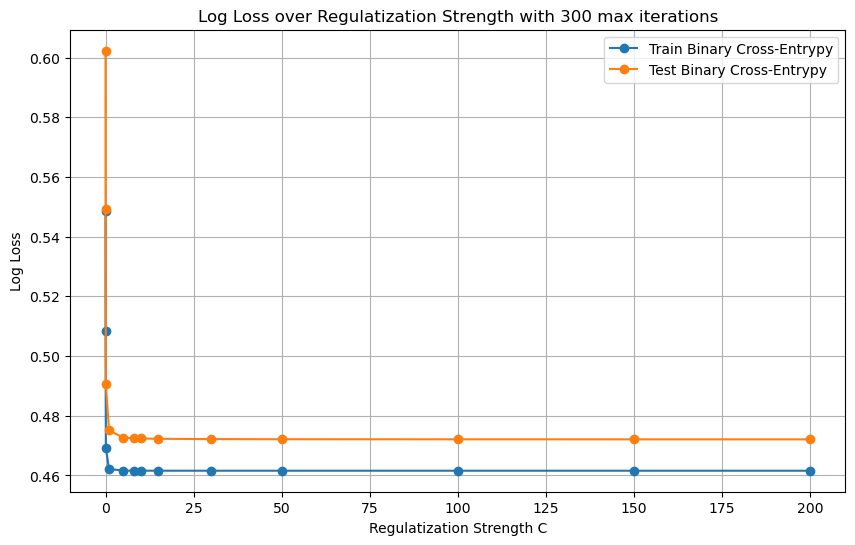

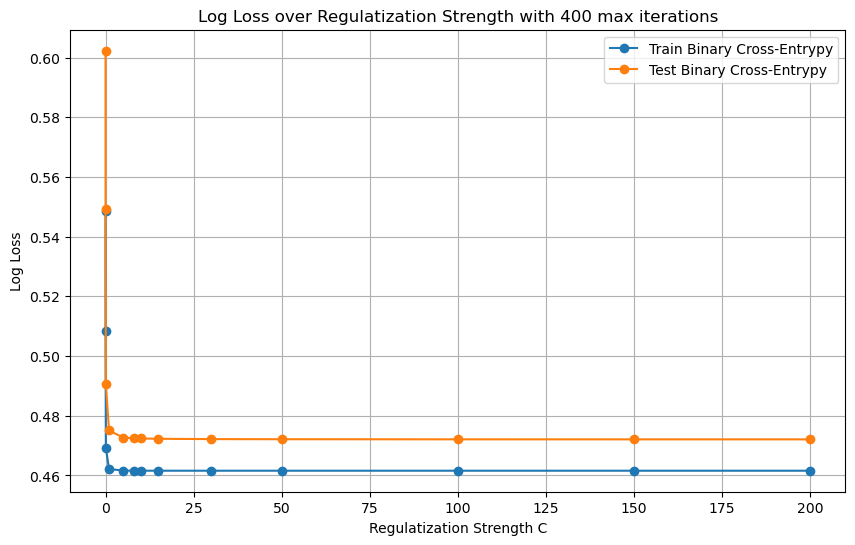

In [743]:
score = None
best_model = None


for max_iter in max_iters:
    train_losses = []
    test_losses = []
    for reg in C_s:
        clf = LogisticRegression(
            random_state=random_state,
            solver=solver,
            # penalty=penalty, ## I do not use None as penalty value since it means no regularization and thus ignoring C parameter
            C=reg,
            max_iter=max_iter
        )
        clf.fit(X_train, y_train)
        current_score = clf.score(X_test, y_test)

        y_train_proba = clf.predict_proba(X_train)
        y_test_proba = clf.predict_proba(X_test)
        
        train_loss = log_loss(y_train, y_train_proba)
        test_loss = log_loss(y_test, y_test_proba)
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)

        if score is None:
            score = current_score
            best_model = clf
        elif current_score > score:
            score = current_score
            best_model = clf

    plot_cross_entropy_n_c(
        x_axis_vals=C_s, 
        train_losses=train_losses, 
        test_losses=test_losses, 
        title=f"Log Loss over Regulatization Strength with {max_iter} max iterations",
        x_label="Regulatization Strength C"
        )


### We can see that learning rate impacts model performance, but epochs do not
### It's underfitting: more complex model is needed/bigger dataset, model did its best

Best classifier parameters:
{'C': 1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 9, 'solver': 'newton-cholesky', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

Best train accuracy score: 0.7855579868708972


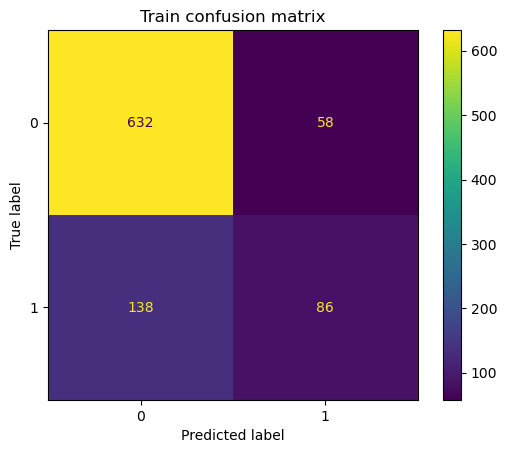


Best test accuracy score: 0.7760814249363868


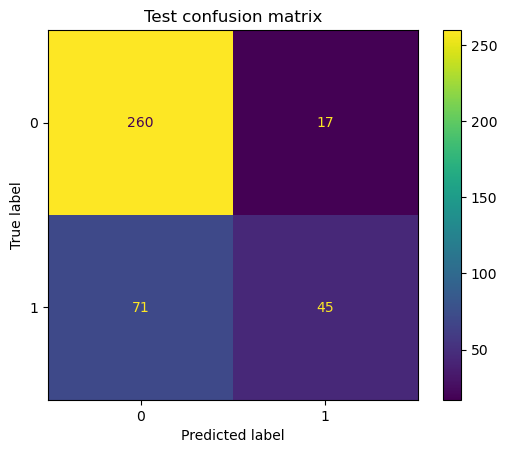

In [744]:
def get_conf_mtrx(y_train: np.ndarray, y_test: np.ndarray, y_train_pred: np.ndarray, y_test_pred: np.ndarray):
    print(f"\nBest train accuracy score: {accuracy_score(y_true=y_train, y_pred=y_train_pred)}")
    plot_conf_mtrx(original=y_train, predicted=y_train_pred, title="Train confusion matrix")
    print(f"\nBest test accuracy score: {score}")
    plot_conf_mtrx(original=y_test, predicted=y_test_pred, title="Test confusion matrix")

print(f"Best classifier parameters:\n{best_model.get_params()}")
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

get_conf_mtrx(
    y_train,
    y_test,
    y_train_pred,
    y_test_pred
)

### SGDClassifier

In [745]:
loss = 'log_loss'
penalty = None
random_state = 9
learning_rate = 'constant'
early_stopping = True

sgd_max_iters = [100, 200, 300, 400, 1000, 100000]
# eta0s = [0.001, 0.01, 0.1, 1, 5, 8, 10, 15, 30, 50, 100, 150, 200]
eta0s = [0.0001, 0.0005, 0.0009, 0.001, 0.005, 0.01, 0.05, 0.09, 0.1, 0.3]
# eta0s = [0.5, 1, 5, 10, 15, 30, 50, 100, 150, 200]



#n_iters_no_change = [5, 10, 20, 30]
n_iters_no_change = [10] # Best parameter


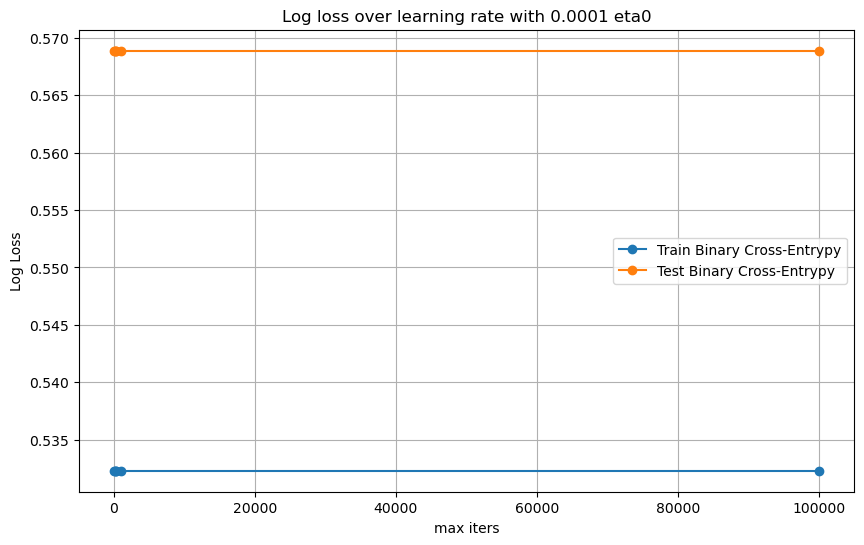

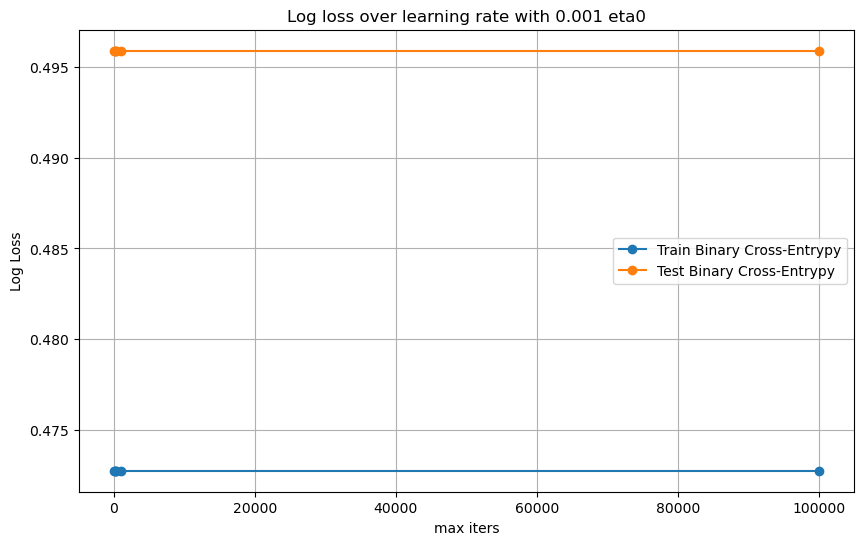

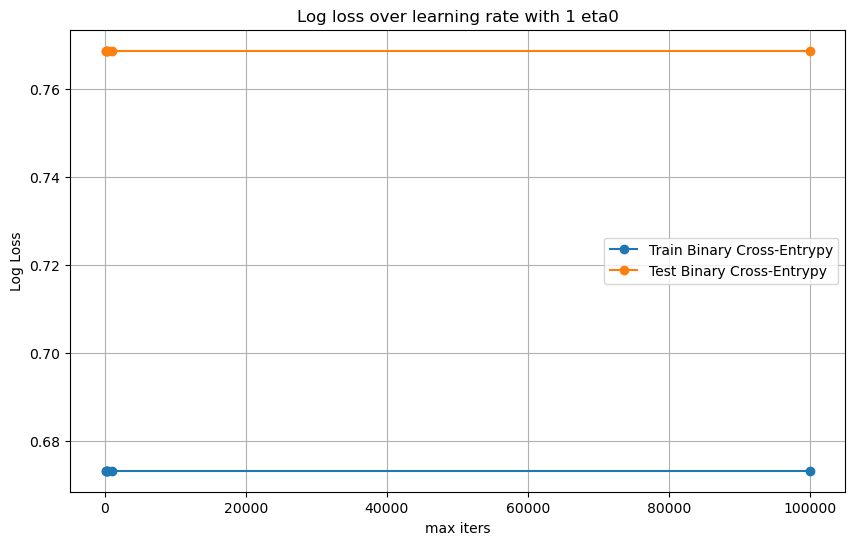

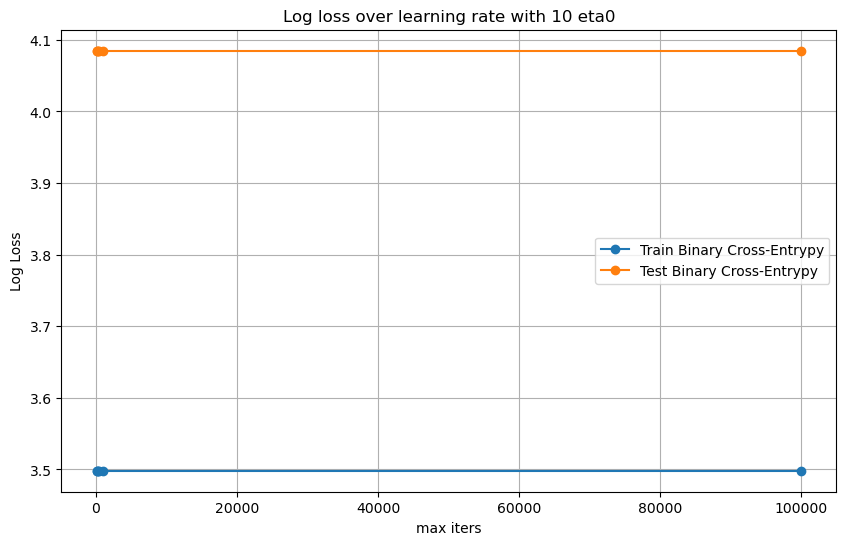

In [746]:
for eta0 in [0.0001, 0.001, 1, 10]:
    train_losses = []
    test_losses = []
    for n_iter_no_change in n_iters_no_change:
        for max_iter in sgd_max_iters:
            clf = SGDClassifier(
                loss=loss,
                random_state=random_state,
                learning_rate=learning_rate,
                penalty=penalty,
                eta0=eta0,
                max_iter=max_iter,
                n_iter_no_change=n_iter_no_change
            )
            clf.fit(X_train, y_train)
            current_score = clf.score(X_test, y_test)

            y_train_proba = clf.predict_proba(X_train)
            y_test_proba = clf.predict_proba(X_test)
            
            train_loss = log_loss(y_train, y_train_proba)
            test_loss = log_loss(y_test, y_test_proba)

            if len(test_losses) == 0 or test_loss < lowest_test_loss:
                best_model = clf
                lowest_test_loss = test_loss

            train_losses.append(train_loss)
            test_losses.append(test_loss)


        plot_cross_entropy_n_c(
            x_axis_vals=sgd_max_iters, 
            train_losses=train_losses, 
            test_losses=test_losses, 
            title=f"Log loss over learning rate with {eta0} eta0",
            x_label="max iters"
            )


### As we can see there is nothing we can do except for expanding dataset

### In my opinion we can observe both underfitting and unrepresentative data

Best classifier parameters:
{'alpha': 0.0001, 'average': False, 'class_weight': None, 'early_stopping': False, 'epsilon': 0.1, 'eta0': 10, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'constant', 'loss': 'log_loss', 'max_iter': 100, 'n_iter_no_change': 10, 'n_jobs': None, 'penalty': None, 'power_t': 0.5, 'random_state': 9, 'shuffle': True, 'tol': 0.001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}

Best train accuracy score: 0.7680525164113785


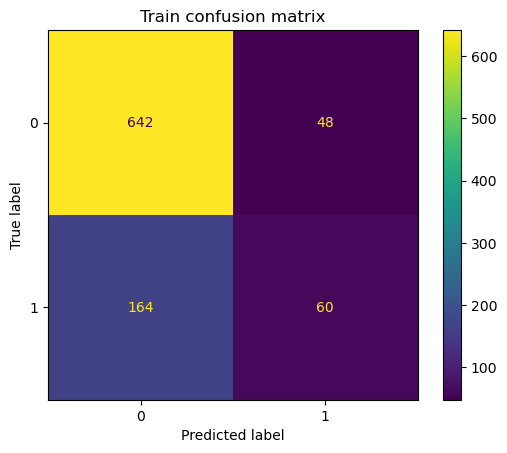


Best test accuracy score: 0.7760814249363868


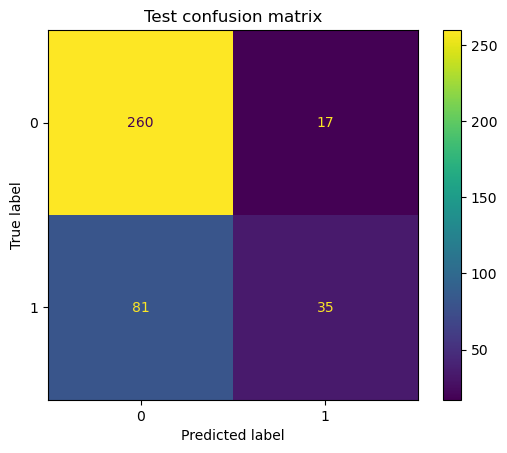

In [747]:
print(f"Best classifier parameters:\n{best_model.get_params()}")
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)
get_conf_mtrx(
    y_train,
    y_test,
    y_train_pred,
    y_test_pred
)

## <a id='lr_pytorch'>Logistic Regression with PyTorch</a>

In [748]:
# Seed
def set_seed(seed):
    """
    The function that sets a random seed to ensure the reproducibility of any randomized processes
    """

    np.random.seed(seed)
    torch.manual_seed(seed)


# Model
class LogisticRegression_torch(nn.Module):
    """
    Logistic Regression model (single neuron Neural Network)
    """

    def __init__(self, in_dim, out_dim):
        super(LogisticRegression_torch, self).__init__()

        self.linear = nn.Linear(in_dim, out_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        z = self.linear(x)
        output = self.sigmoid(z)
        return output

In [749]:
class LogisticRegression_trainer:
    def __init__(self, lr: int):
        set_seed(9)

        self.criterion = nn.BCELoss()
        self.in_dim, self.out_dim = 9, 1
        self.model = LogisticRegression_torch(self.in_dim, self.out_dim)
        self.optimizer_name = None
        self.optimizer = None
        self.lr = lr
        self.epochs = None
        self.train_loader = None
        self.test_loader = None
        self.train_metrics = []
        self.test_metrics = []
        self.models_dir = "./models_states"


    def set_optimizer(self, optimizer_name: str, optimizer_func):
        self.optimizer = optimizer_func(self.model.parameters(), lr=self.lr)
        self.optimizer_name = optimizer_name

    def set_epochs(self, epochs: int):
        self.epochs = epochs

    def prepare_loaders(self, X_train: np.ndarray, X_test: np.ndarray, y_train: np.ndarray, y_test: np.ndarray) -> dict:
        y_train_torch = torch.from_numpy(y_train.astype(np.float32))
        x_train_torch = torch.from_numpy(X_train.astype(np.float32))
        y_test_torch = torch.from_numpy(y_test.astype(np.float32))
        x_test_torch = torch.from_numpy(X_test.astype(np.float32))

        train = TensorDataset(x_train_torch, y_train_torch)
        test = TensorDataset(x_test_torch, y_test_torch)
        train_loader = DataLoader(dataset = train, batch_size = 100, shuffle = True)
        test_loader = DataLoader(dataset = test, batch_size = 100, shuffle = True)

        self.train_loader = train_loader
        self.test_loader = test_loader

        return {
            "train": train_loader,
            "test": test_loader
        }

    def __optimize_weights(self) -> float:
        for i, (x_tr, y_tr) in enumerate(self.train_loader):
            # Compute predictions
            outputs = self.model(x_tr)
            # Compute Loss for predictions
            loss = self.criterion(outputs, y_tr.reshape(-1, 1))
            # Remove previous gradients
            self.optimizer.zero_grad()
            # Compute current gradients
            loss.backward()
            # Update parameters
            self.optimizer.step()
            # Save training Loss
            return loss.item()

    def __count_test_loss(self) -> float:
        with torch.no_grad():
            for x_ts, y_ts in self.test_loader:

                # Compute predictions
                outputs = self.model(x_ts)
                # Compute Loss for predictions
                loss = self.criterion(outputs, y_ts.reshape(-1, 1))
                # Save validation Loss
                return loss.item()

    def epoch_train(self, epoch_val: int, prev_epochs: int):

        for epoch in range(epoch_val):
            train_loss = []
            self.model.train()

            train_loss.append(self.__optimize_weights())

            # Count train loss
            train_mean_loss = sum(train_loss) / len(train_loss)
            self.train_metrics.append(train_mean_loss)

            # Count test loss
            self.model.eval()
            test_loss = []
            test_loss.append(self.__count_test_loss())

            # Get mean of  Validation Loss per epoch
            test_mean_loss = sum(test_loss) / len(test_loss)
            self.test_metrics.append(test_mean_loss)

            self.__save_parameters(
                epoch=epoch,
                prev_epochs=prev_epochs,
                model_name=f"LogisticRegression_{self.optimizer_name}"
            )

            print(f'Train Epoch: {epoch} \t [Train Loss]: {train_mean_loss:.6f} \t [Test Loss]: {test_mean_loss:.6f}')

    def full_train(self, epochs_list: list, optimizers_list: list):
        for optimizer_name, optimizer_func in optimizers_list.items():
            model_name = f'LogisticRegression_{optimizer_name}'
            self.__set_optimizer(optimizer_func)

            # Start training
            for ind, epoch in enumerate(epochs_list):
                self.__epoch_train(epoch_val=epoch)


    def plot_metrics(self, epochs: int):
        plt.figure(figsize=(10, 5))
        plt.plot(range(epochs), self.train_metrics, label='Training Loss')
        plt.plot(range(epochs), self.test_metrics, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('BCE')
        plt.title(f"Training and Validation BCE over Epochs via {self.optimizer_name}")
        plt.legend()
        plt.grid(True)
        plt.show()

    def __save_parameters(self, epoch: int, prev_epochs: int, model_name: str):
        save_path = f'{self.models_dir}/{model_name}/epoch_{epoch + prev_epochs + 1}.pth'

        if not os.path.exists(f'{self.models_dir}/{model_name}'):
            os.makedirs(f'{self.models_dir}/{model_name}')

        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'train_loss': self.train_metrics[epoch + prev_epochs],
            'test_loss': self.test_metrics[epoch + prev_epochs],
        }, save_path)

        if not os.path.exists(save_path):
            raise IOError(f"Failed to save the model at {save_path}")
        
    def load_model_state(self, model: LogisticRegression_torch, optimizer, optimizer_name: str, epoch: int):
        checkpoint_path = f'{self.models_dir}/LogisticRegression_{optimizer_name}/epoch_{epoch}.pth'
    
        if not os.path.exists(checkpoint_path):
            raise FileNotFoundError(f"No such file or directory: '{checkpoint_path}'")

        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        return checkpoint['epoch'], checkpoint['train_loss'], checkpoint['test_loss']
    
    def clear_main_values(self):
        self.model = LogisticRegression_torch(self.in_dim, self.out_dim)
        self.optimizer_name = None
        self.optimizer = None
        self.epochs = None
        self.train_metrics = []
        self.test_metrics = []


In [750]:
lr = 50
optimizers_list = {
    "Adam": torch.optim.Adam,
    "RMSprop": torch.optim.RMSprop
}
epochs_list = [40, 10, 5]

Train Epoch: 0 	 [Train Loss]: 0.726981 	 [Test Loss]: 0.713345
Train Epoch: 1 	 [Train Loss]: 0.686524 	 [Test Loss]: 0.697822
Train Epoch: 2 	 [Train Loss]: 0.658967 	 [Test Loss]: 0.672182
Train Epoch: 3 	 [Train Loss]: 0.639564 	 [Test Loss]: 0.613742
Train Epoch: 4 	 [Train Loss]: 0.596067 	 [Test Loss]: 0.637834
Train Epoch: 5 	 [Train Loss]: 0.641974 	 [Test Loss]: 0.672735
Train Epoch: 6 	 [Train Loss]: 0.545657 	 [Test Loss]: 0.613628
Train Epoch: 7 	 [Train Loss]: 0.563315 	 [Test Loss]: 0.578602


Train Epoch: 8 	 [Train Loss]: 0.631760 	 [Test Loss]: 0.589803
Train Epoch: 9 	 [Train Loss]: 0.507830 	 [Test Loss]: 0.611830
Train Epoch: 10 	 [Train Loss]: 0.601570 	 [Test Loss]: 0.616771
Train Epoch: 11 	 [Train Loss]: 0.557239 	 [Test Loss]: 0.596364
Train Epoch: 12 	 [Train Loss]: 0.547985 	 [Test Loss]: 0.570923
Train Epoch: 13 	 [Train Loss]: 0.532630 	 [Test Loss]: 0.565240
Train Epoch: 14 	 [Train Loss]: 0.513384 	 [Test Loss]: 0.547349
Train Epoch: 15 	 [Train Loss]: 0.516783 	 [Test Loss]: 0.534038
Train Epoch: 16 	 [Train Loss]: 0.469184 	 [Test Loss]: 0.619644
Train Epoch: 17 	 [Train Loss]: 0.487026 	 [Test Loss]: 0.600264
Train Epoch: 18 	 [Train Loss]: 0.463697 	 [Test Loss]: 0.588158
Train Epoch: 19 	 [Train Loss]: 0.569576 	 [Test Loss]: 0.502878
Train Epoch: 20 	 [Train Loss]: 0.535874 	 [Test Loss]: 0.543732
Train Epoch: 21 	 [Train Loss]: 0.602442 	 [Test Loss]: 0.448556
Train Epoch: 22 	 [Train Loss]: 0.524535 	 [Test Loss]: 0.623921
Train Epoch: 23 	 [Train Lo

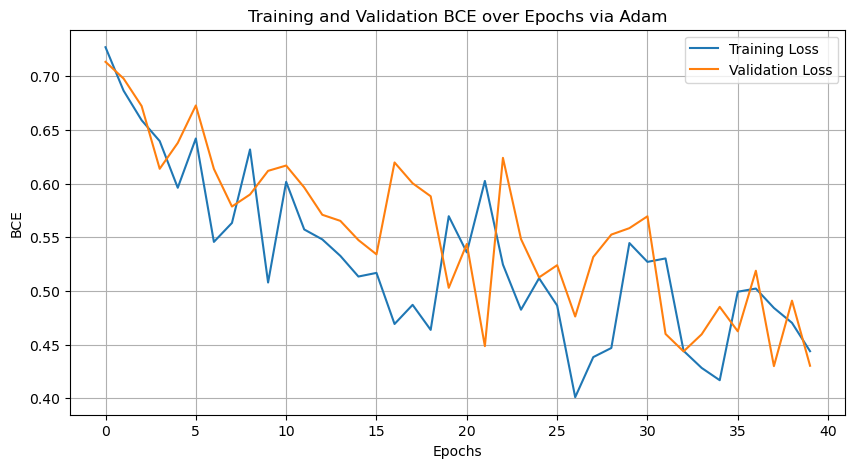

Train Epoch: 0 	 [Train Loss]: 0.438415 	 [Test Loss]: 0.471909
Train Epoch: 1 	 [Train Loss]: 0.436686 	 [Test Loss]: 0.554262
Train Epoch: 2 	 [Train Loss]: 0.498944 	 [Test Loss]: 0.624196
Train Epoch: 3 	 [Train Loss]: 0.417845 	 [Test Loss]: 0.589138
Train Epoch: 4 	 [Train Loss]: 0.452406 	 [Test Loss]: 0.486459
Train Epoch: 5 	 [Train Loss]: 0.559010 	 [Test Loss]: 0.507872
Train Epoch: 6 	 [Train Loss]: 0.462844 	 [Test Loss]: 0.520359
Train Epoch: 7 	 [Train Loss]: 0.426104 	 [Test Loss]: 0.511672
Train Epoch: 8 	 [Train Loss]: 0.459633 	 [Test Loss]: 0.490778
Train Epoch: 9 	 [Train Loss]: 0.504160 	 [Test Loss]: 0.447809


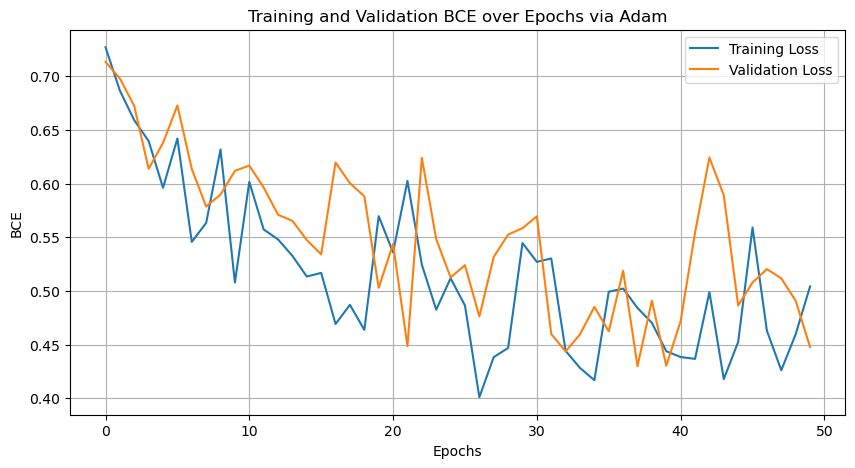

Train Epoch: 0 	 [Train Loss]: 0.671851 	 [Test Loss]: 0.460228
Train Epoch: 1 	 [Train Loss]: 0.466957 	 [Test Loss]: 0.545488
Train Epoch: 2 	 [Train Loss]: 0.395544 	 [Test Loss]: 0.449603
Train Epoch: 3 	 [Train Loss]: 0.458377 	 [Test Loss]: 0.492569
Train Epoch: 4 	 [Train Loss]: 0.536274 	 [Test Loss]: 0.448632


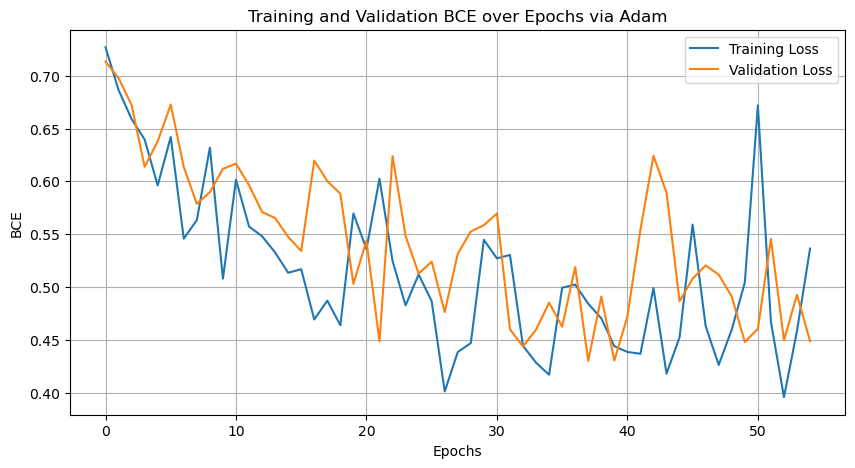

Train Epoch: 0 	 [Train Loss]: 0.755902 	 [Test Loss]: 0.672723
Train Epoch: 1 	 [Train Loss]: 0.596728 	 [Test Loss]: 0.541544
Train Epoch: 2 	 [Train Loss]: 0.534517 	 [Test Loss]: 0.428570
Train Epoch: 3 	 [Train Loss]: 0.509067 	 [Test Loss]: 0.570544
Train Epoch: 4 	 [Train Loss]: 0.541537 	 [Test Loss]: 0.574435
Train Epoch: 5 	 [Train Loss]: 0.478465 	 [Test Loss]: 0.475270
Train Epoch: 6 	 [Train Loss]: 0.550842 	 [Test Loss]: 0.532973
Train Epoch: 7 	 [Train Loss]: 0.527013 	 [Test Loss]: 0.483869
Train Epoch: 8 	 [Train Loss]: 0.528145 	 [Test Loss]: 0.482326
Train Epoch: 9 	 [Train Loss]: 0.503154 	 [Test Loss]: 0.531005
Train Epoch: 10 	 [Train Loss]: 0.462097 	 [Test Loss]: 0.503349
Train Epoch: 11 	 [Train Loss]: 0.472079 	 [Test Loss]: 0.460613
Train Epoch: 12 	 [Train Loss]: 0.434381 	 [Test Loss]: 0.493412
Train Epoch: 13 	 [Train Loss]: 0.508338 	 [Test Loss]: 0.479304
Train Epoch: 14 	 [Train Loss]: 0.446853 	 [Test Loss]: 0.479616
Train Epoch: 15 	 [Train Loss]: 0.4

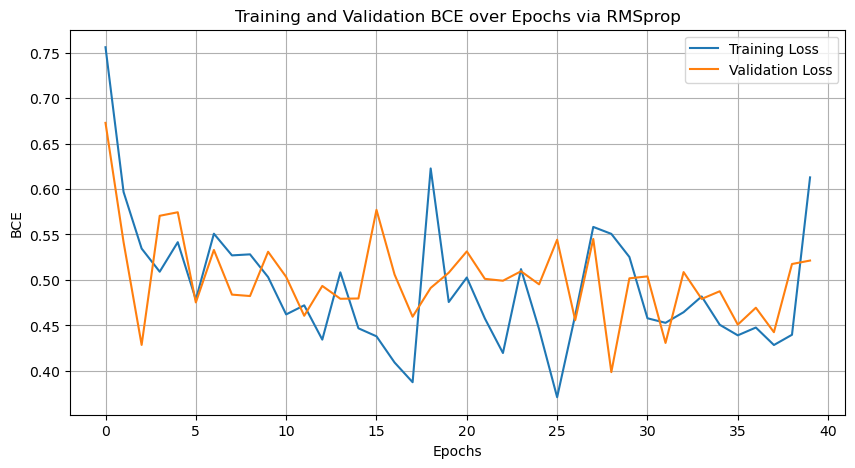

Train Epoch: 0 	 [Train Loss]: 0.419251 	 [Test Loss]: 0.485095
Train Epoch: 1 	 [Train Loss]: 0.549324 	 [Test Loss]: 0.492352
Train Epoch: 2 	 [Train Loss]: 0.440464 	 [Test Loss]: 0.525946
Train Epoch: 3 	 [Train Loss]: 0.458771 	 [Test Loss]: 0.496588
Train Epoch: 4 	 [Train Loss]: 0.494169 	 [Test Loss]: 0.501358
Train Epoch: 5 	 [Train Loss]: 0.542185 	 [Test Loss]: 0.545943
Train Epoch: 6 	 [Train Loss]: 0.430457 	 [Test Loss]: 0.488353
Train Epoch: 7 	 [Train Loss]: 0.425673 	 [Test Loss]: 0.466459
Train Epoch: 8 	 [Train Loss]: 0.526545 	 [Test Loss]: 0.389837
Train Epoch: 9 	 [Train Loss]: 0.417977 	 [Test Loss]: 0.436360


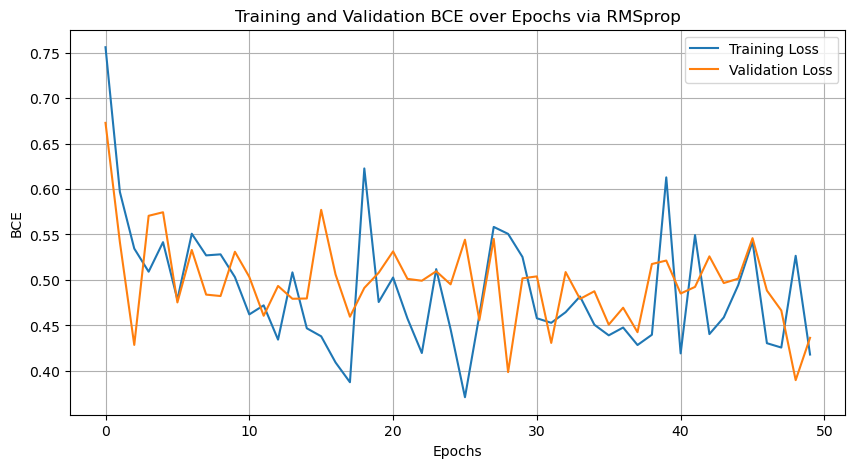

Train Epoch: 0 	 [Train Loss]: 0.576196 	 [Test Loss]: 0.463313
Train Epoch: 1 	 [Train Loss]: 0.504680 	 [Test Loss]: 0.419596
Train Epoch: 2 	 [Train Loss]: 0.476842 	 [Test Loss]: 0.456031
Train Epoch: 3 	 [Train Loss]: 0.461646 	 [Test Loss]: 0.415474
Train Epoch: 4 	 [Train Loss]: 0.488395 	 [Test Loss]: 0.552848


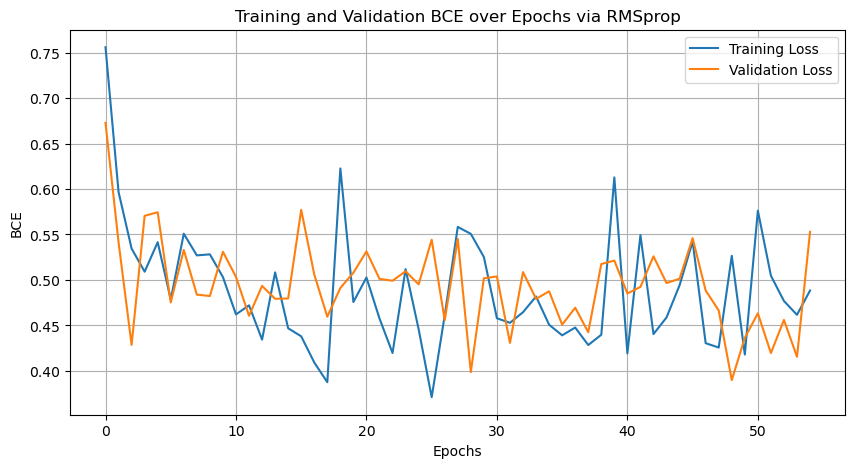

In [751]:
trainer = LogisticRegression_trainer(lr=0.05)
trainer.prepare_loaders(
        X_train,
        X_test,
        y_train,
        y_test
)

best_parameters = {}

for optimizer_name, optimizer_func in optimizers_list.items():
        trainer.set_optimizer(optimizer_name, optimizer_func)

        # Start training
        for ind, epoch in enumerate(epochs_list):
                trainer.set_epochs(epoch)
                trainer.epoch_train(epoch_val=epoch, prev_epochs=sum(epochs_list[:ind]))

                trainer.plot_metrics(epochs=sum(epochs_list[:ind]) + epoch)

        best_epoch = trainer.test_metrics.index(min(trainer.test_metrics))
        best_epoch += 1 ## Since we count from 0
        best_parameters[optimizer_name] = {"epoch": best_epoch, "min_loss": min(trainer.test_metrics)}
        trainer.clear_main_values()

del(trainer)

In [752]:
print(f"best_parameters: {best_parameters}\n")
min_loss_key = min(best_parameters, key=lambda k: best_parameters[k]['min_loss'])

# Get the key-value pair
final_hyperparameters = {min_loss_key: best_parameters[min_loss_key]}
final_hyperparameters

best_parameters: {'Adam': {'epoch': 38, 'min_loss': 0.4299355447292328}, 'RMSprop': {'epoch': 49, 'min_loss': 0.3898368775844574}}



{'RMSprop': {'epoch': 49, 'min_loss': 0.3898368775844574}}

### Based on plots we can observe that learning went a bit smoother with RMSprop optimizer
### RMSprop optimizer also has given the best results

In [753]:
def load_model_state(model: LogisticRegression_torch, optimizer, model_name: str, epoch: int, model_states_dir: str):
    checkpoint_path = f'{model_states_dir}/{model_name}/epoch_{epoch}.pth'
    
    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"No such file or directory: '{checkpoint_path}'")

    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return checkpoint['epoch'], checkpoint['train_loss'], checkpoint['test_loss']


def load_best_model(epoch: int, optimizer_name: str):
    best_model = LogisticRegression_torch(9, 1)
    optimizer = optimizers_list[optimizer_name](best_model.parameters(), lr=lr)
    load_model_state(best_model, optimizer, f'LogisticRegression_{optimizer_name}', epoch, "./models_states")
    return best_model, optimizer

In [754]:
best_optimizer_name = list(final_hyperparameters.keys())[0]
best_epoch_value = final_hyperparameters[best_optimizer_name]["epoch"]

final_model, _ = load_best_model(best_epoch_value, best_optimizer_name)

train_accuracy = 0.7899


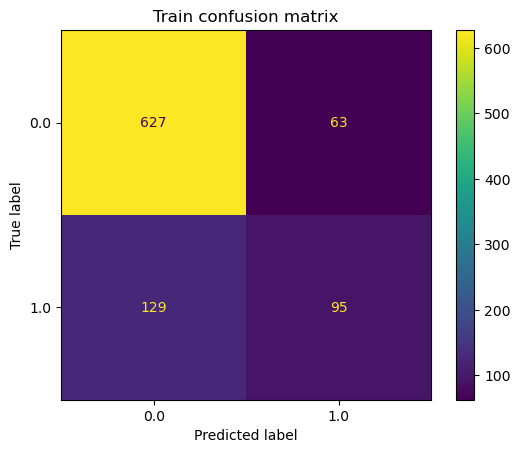

test_accuracy = 0.7837


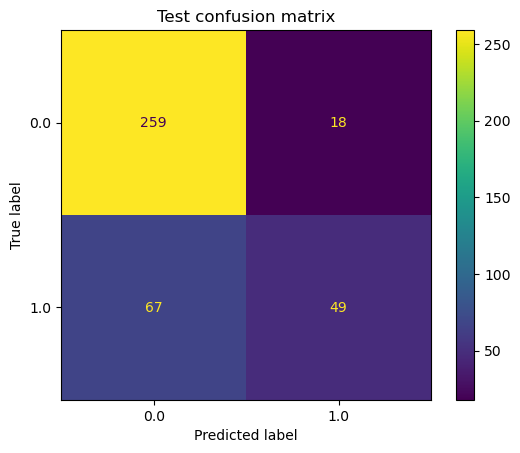

In [755]:
y_train_torch = torch.from_numpy(y_train.astype(np.float32))
x_train_torch = torch.from_numpy(X_train.astype(np.float32))
y_test_torch = torch.from_numpy(y_test.astype(np.float32))
x_test_torch = torch.from_numpy(X_test.astype(np.float32))

with torch.no_grad():

    y_pred_train = final_model(x_train_torch)
    # transform probabilities into classes
    y_pred_train_class = y_pred_train.round()
    train_acc = torch.sum(y_pred_train_class == y_train_torch.reshape(-1, 1)) / y_train_torch.shape[0]

    print(f'train_accuracy = {train_acc:.4f}')
    plot_conf_mtrx(original=y_train_torch.numpy(), predicted=y_pred_train_class.numpy(), title="Train confusion matrix")

    y_pred_test = final_model(x_test_torch)
    # transform probabilities into classes
    y_pred_test_class = y_pred_test.round()
    test_acc = torch.sum(y_pred_test_class == y_test_torch.reshape(-1, 1)) / y_test_torch.shape[0]

    print(f'test_accuracy = {test_acc:.4f}')
    plot_conf_mtrx(original=y_test_torch.numpy(), predicted=y_pred_test_class.numpy(), title="Test confusion matrix")


### Results are quite poor like for LogisticRegression and SGDClassifier from scikit-learn. We can say, that datasets both train and validation are kinda unrepresentative, probably too much "noize". But it's a good fit for current dataset.
#### Have to notice, that without one-hot encoding accuracy is less by ~0.02